# Importing some packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import f_classif, chi2
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

from boruta import BorutaPy

from BorutaShap import BorutaShap

from collections import Counter

import shap

import os
from pathlib import Path

from bisect import bisect

import re

import gc

from tqdm.autonotebook import tqdm

import warnings 
warnings.filterwarnings('ignore')

c:\Users\vchar\anaconda3\envs\ml_projects\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data

In [2]:
data_path = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\VehicleLoanDefault/\data")

train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))
info_df = pd.read_csv(os.path.join(data_path, 'data_dictionary.csv'))

# getting some numerical features' names from beurau data
bearue_num_feats_list = list(info_df.iloc[22:, :]['Variable Name'].values)
bearue_num_feats_list.remove('AVERAGE.ACCT.AGE')
bearue_num_feats_list.remove('CREDIT.HISTORY.LENGTH')
bearue_num_feats_list.extend(['avg_loan_tenure', 'hist_length'])

# Feature engineering

## Creating some features

In [3]:
signs = [(1,20,"Cap"), (2,18,"Aqu"), (3,20,"Pis"), (4,20,"Ari"),
         (5,21,"Tau"), (6,21,"Gem"), (7,22,"Can"), (8,23,"Leo"),
         (9,23,"Vir"), (10,23,"Lib"), (11,22,"Sco"), (12,22,"Sag"),
         (12,31,"Cap")]

def zodiac_sign(m,d):
    return signs[bisect(signs,(m,d))][2]

train_df['DisbursalDate'] = pd.to_datetime(train_df['DisbursalDate'])#, format="%Y-%m-%d")
train_df['Date.of.Birth'] = pd.to_datetime(train_df['Date.of.Birth'])#, format="%Y-%m-%d")
train_df['age'] = round((train_df['DisbursalDate'] - train_df['Date.of.Birth']).dt.days / 365, 1)

train_df['disb_month'] = train_df['DisbursalDate'].dt.month
train_df['zodiac_sign'] = train_df['Date.of.Birth'].apply(lambda x: zodiac_sign(x.month, x.day))

def convert2numbers(x):
    derived_numbers = re.findall(r'(\d+)yrs (\d+)mon', x)
    return round(int(derived_numbers[0][0]) + int(derived_numbers[0][1]) / 12, 2)

train_df['avg_loan_tenure'] = train_df['AVERAGE.ACCT.AGE'].apply(convert2numbers)
train_df['hist_length'] = train_df['CREDIT.HISTORY.LENGTH'].apply(convert2numbers)

score_desc_list = list(train_df['PERFORM_CNS.SCORE.DESCRIPTION'].unique())
score_desc_map_dict = {score_desc_list[i]: i+1 for i in range(len(score_desc_list))}

train_df['score_desc'] = train_df['PERFORM_CNS.SCORE.DESCRIPTION'].map(score_desc_map_dict)

train_df['Employment.Type'].fillna('Unknown', inplace=True)

employment_type_list = list(train_df['Employment.Type'].unique())
employment_type_map_dict = {employment_type_list[i]: i+1 for i in range(len(employment_type_list))}

train_df['Employment.Type'] = train_df['Employment.Type'].map(employment_type_map_dict)

zodiac_list = list(train_df['zodiac_sign'].unique())
zodiac_map_dict = {zodiac_list[i]: i+1 for i in range(len(zodiac_list))}

train_df['zodiac_sign'] = train_df['zodiac_sign'].map(zodiac_map_dict)

for i in range(len(bearue_num_feats_list)):
    for j in range(len(bearue_num_feats_list)):
        if i != j:
            train_df[f"{bearue_num_feats_list[i]}_ratio{j+1}"] = train_df[bearue_num_feats_list[i]] / \
                (train_df[bearue_num_feats_list[j]] + 1000)
            
created_ratio_list = [col for col in train_df.columns if '_ratio' in col]

train_df.drop(
    columns=[
        'DisbursalDate', 'Date.of.Birth', 
        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH',
        'PERFORM_CNS.SCORE.DESCRIPTION', 'MobileNo_Avl_Flag'
    ], 
    inplace=True
)

score_desc_map_dict

{'No Bureau History Available': 1,
 'I-Medium Risk': 2,
 'L-Very High Risk': 3,
 'A-Very Low Risk': 4,
 'Not Scored: Not Enough Info available on the customer': 5,
 'D-Very Low Risk': 6,
 'M-Very High Risk': 7,
 'B-Very Low Risk': 8,
 'C-Very Low Risk': 9,
 'E-Low Risk': 10,
 'H-Medium Risk': 11,
 'F-Low Risk': 12,
 'K-High Risk': 13,
 'Not Scored: No Activity seen on the customer (Inactive)': 14,
 'Not Scored: Sufficient History Not Available': 15,
 'Not Scored: No Updates available in last 36 months': 16,
 'G-Low Risk': 17,
 'J-High Risk': 18,
 'Not Scored: Only a Guarantor': 19,
 'Not Scored: More than 50 active Accounts found': 20}

In [4]:
employment_type_map_dict

{'Salaried': 1, 'Self employed': 2, 'Unknown': 3}

In [5]:
zodiac_map_dict

{'Cap': 1,
 'Leo': 2,
 'Vir': 3,
 'Ari': 4,
 'Sco': 5,
 'Can': 6,
 'Aqu': 7,
 'Tau': 8,
 'Pis': 9,
 'Lib': 10,
 'Gem': 11,
 'Sag': 12}

In [6]:
test_df['DisbursalDate'] = pd.to_datetime(test_df['DisbursalDate'])#, format="%d-%m-%Y")
test_df['Date.of.Birth'] = pd.to_datetime(test_df['Date.of.Birth'])#, format="%d-%m-%Y")
test_df['age'] = round((test_df['DisbursalDate'] - test_df['Date.of.Birth']).dt.days / 365, 1)

test_df['disb_month'] = test_df['DisbursalDate'].dt.month
test_df['zodiac_sign'] = test_df['Date.of.Birth'].apply(lambda x: zodiac_sign(x.month, x.day))

test_df['avg_loan_tenure'] = test_df['AVERAGE.ACCT.AGE'].apply(convert2numbers)
test_df['hist_length'] = test_df['CREDIT.HISTORY.LENGTH'].apply(convert2numbers)

test_df['score_desc'] = test_df['PERFORM_CNS.SCORE.DESCRIPTION'].map(score_desc_map_dict)

test_df['Employment.Type'].fillna('Unknown', inplace=True)

test_df['Employment.Type'] = test_df['Employment.Type'].map(employment_type_map_dict)

test_df['zodiac_sign'] = test_df['zodiac_sign'].map(zodiac_map_dict)

for i in range(len(bearue_num_feats_list)):
    for j in range(len(bearue_num_feats_list)):
        if i != j:
            test_df[f"{bearue_num_feats_list[i]}_ratio{j+1}"] = test_df[bearue_num_feats_list[i]] / \
                (test_df[bearue_num_feats_list[j]] + 1000)

test_df.drop(
    columns=[
        'DisbursalDate', 'Date.of.Birth', 
        'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH',
        'PERFORM_CNS.SCORE.DESCRIPTION', 'MobileNo_Avl_Flag'
    ], 
    inplace=True
)

## Creating folds

In [7]:
skfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skfold_list = []
for train_idxs, valid_idxs in skfold.split(train_df, y=train_df['loan_default']):
    skfold_list.append((train_idxs, valid_idxs))

# Features selection and model construction

In [8]:
def get_iqr(x):
     iqr = np.quantile(x, 0.75) - np.quantile(x, 0.25)
     return iqr

def get_q25(x):
     return np.quantile(x, 0.25)

def get_q75(x):
     return np.quantile(x, 0.75) 

## Function for feature selection

In [9]:
class FSelector():

    def __init__(self, X, y, num_feats, ordinal_feats, nominal_feats, model, is_target_cat=True, select_n_feats=15):

        self.X = X
        self.y = y
        self.num_feats = num_feats
        self.ordinal_feats = ordinal_feats
        self.nominal_feats = nominal_feats
        self.model = model
        self.is_target_cat = is_target_cat
        self.select_n_feats = select_n_feats

    def calculate_vif(self, X):
    
        vif = pd.DataFrame()
        vif["features"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        return vif

    def select_feats_via_vif(self):

        num_features = self.num_feats.copy()

        vif_df = self.calculate_vif(self.X[num_features])

        while vif_df[vif_df['VIF']>=10].shape[0] != 0:
            vif_df.sort_values('VIF', ascending=False, inplace=True)
            vif_df.reset_index(drop=True, inplace=True)
            # print(vif_df)
            elimination_candidate = vif_df.iloc[0]['features']
            # print(elimination_candidate)
            num_features = [i for i in num_features if i!=elimination_candidate]
            new_X = self.X[num_features]
            vif_df = self.calculate_vif(new_X)

        return list(vif_df['features'].values)
    
    def get_spearmanr(self, X, y):
        # return np.array([stats.spearmanr(X.values[:, f], y.values).correlation for f in range(X.shape[1])])
        spearman_values = [stats.spearmanr(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
        temp_sp_df = pd.DataFrame({'spearman': spearman_values, 'feats': list(X.columns)})
        temp_sp_df['abs_spearman'] = np.abs(temp_sp_df['spearman'])
        temp_sp_df.sort_values('abs_spearman', ascending=False, inplace=True)
        temp_sp_df.reset_index(drop=True, inplace=True)
        return temp_sp_df.iloc[:15]['feats'].to_list()
    
    def get_kendalltau(self, X, y):
        # return [stats.kendalltau(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
        kendall_values = [stats.spearmanr(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
        temp_ken_df = pd.DataFrame({'kendall': kendall_values, 'feats': list(X.columns)})
        temp_ken_df['abs_kendall'] = np.abs(temp_ken_df['kendall'])
        temp_ken_df.sort_values('abs_kendall', ascending=False, inplace=True)
        temp_ken_df.reset_index(drop=True, inplace=True)
        return temp_ken_df.iloc[:15]['feats'].to_list()
    
    def get_pointbiserialr(self, X, y):
        return [stats.pointbiserialr(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
    
    def get_boruto_feats(self):
        feat_selector = BorutaPy(self.model, n_estimators='auto', verbose=2, random_state=1)
        feat_selector.fit(np.array(self.X), np.array(self.y))
        boruta_selected_features = list(self.X.iloc[:, feat_selector.support_].columns)
        return boruta_selected_features
    
    def get_kbest(self, X, feats_list, metric):
        selector = SelectKBest(metric, k=self.select_n_feats)
        selector.fit_transform(X[feats_list], self.y)
        selected_feats_idxs_list = list(selector.get_support(indices=True))
        column_names = [feats_list[i] for i in selected_feats_idxs_list]
        return column_names
    
    def get_rfe_feats(self):
        model_rfe = RFE(self.model, n_features_to_select=self.select_n_feats)
        model_rfe.fit(self.X, self.y)
        model_rfe_feats = list(self.X.iloc[:, list(model_rfe.support_)].columns)
        return model_rfe_feats
    
    def get_votes(self):

        if self.num_feats is not None:

            if self.is_target_cat:

                # self.num_kendalltau_feats = self.get_kendalltau(self.X[self.num_feats], self.y)
                self.num_f_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=f_classif)
                self.num_mi_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=mutual_info_classif)

                self.selected_num_feats = []
                # self.selected_num_feats.extend(self.num_kendalltau_feats)
                self.selected_num_feats.extend(self.num_f_feats)
                self.selected_num_feats.extend(self.num_mi_feats)

            else:

                self.vif_feats = self.select_feats_via_vif()

                self.pearson_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=r_regression, k=self.select_n_feats)
                # self.num_spearmanr_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=stats.spearmanr, k=self.select_n_feats)
                # self.num_kendalltau_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=stats.kendalltau, k=self.select_n_feats)
                self.num_spearmanr_feats = self.get_spearmanr(self.X[self.num_feats], self.y)
                self.num_kendalltau_feats = self.get_kendalltau(self.X[self.num_feats], self.y)
                # self.num_spearmanr_feats = SelectKBest(self.get_spearmanr, k=self.select_n_feats).fit_transform(self.X[self.num_feats], self.y)
                # self.num_kendalltau_feats = SelectKBest(self.get_kendalltau, k=self.select_n_feats).fit_transform(self.X[self.num_feats], self.y)

                self.selected_num_feats = []
                self.selected_num_feats.extend(self.pearson_feats)
                self.selected_num_feats.extend(self.num_spearmanr_feats)
                self.selected_num_feats.extend(self.num_kendalltau_feats)
                # self.selected_num_feats = list(set(self.selected_num_feats))

        if self.ordinal_feats is not None:

            if self.is_target_cat:

                self.ordinal_mi_feats = self.get_kbest(X=self.X, feats_list=self.ordinal_feats, metric=mutual_info_classif)
                self.ordinal_chi2_feats = self.get_kbest(X=self.X, feats_list=self.ordinal_feats, metric=chi2)

                self.selected_ordinal_feats = []
                self.selected_ordinal_feats.extend(self.ordinal_mi_feats)
                self.selected_ordinal_feats.extend(self.ordinal_chi2_feats)

            else:

                self.ordinal_spearmanr_feats = self.get_spearmanr(self.X[self.ordinal_feats], self.y)
                self.ordinal_kendalltau_feats = self.get_kendalltau(self.X[self.ordinal_feats], self.y)

                # self.ordinal_spearmanr_feats = self.get_kbest(X=self.X, feats_list=self.ordinal_feats, metric=stats.spearmanr, k=self.select_n_feats)
                # self.ordinal_kendalltau_feats = self.get_kbest(X=self.X, feats_list=self.ordinal_feats, metric=stats.kendalltau, k=self.select_n_feats)

                # self.ordinal_spearmanr_feats = SelectKBest(self.get_spearmanr, k=self.select_n_feats).fit_transform(self.X[self.ordinal_feats], self.y)
                # self.ordinal_kendalltau_feats = SelectKBest(self.get_kendalltau, k=self.select_n_feats).fit_transform(self.X[self.ordinal_feats], self.y)

                self.selected_ordinal_feats = []
                self.selected_ordinal_feats.extend(self.ordinal_spearmanr_feats)
                self.selected_ordinal_feats.extend(self.ordinal_kendalltau_feats)
                # self.selected_ordinal_feats = list(set(self.selected_ordinal_feats))

        if self.nominal_feats is not None:

            if self.is_target_cat:

                self.nominal_mi_feats = self.get_kbest(X=self.X, feats_list=self.nominal_feats, metric=mutual_info_classif)
                self.nominal_chi2_feats = self.get_kbest(X=self.X, feats_list=self.nominal_feats, metric=chi2)

                self.selected_nominal_feats = []
                self.selected_nominal_feats.extend(self.nominal_mi_feats)
                self.selected_nominal_feats.extend(self.nominal_chi2_feats)

            else:

                self.f_feats = self.get_kbest(X=self.X, feats_list=self.nominal_feats, metric=f_classif, k=self.select_n_feats)
                self.mi_feats = self.get_kbest(X=self.X, feats_list=self.nominal_feats, metric=mutual_info_regression, k=self.select_n_feats)

                # # self.f_feats = f_classif(self.X[self.nominal_feats], self.y)[0]
                # self.f_feats = SelectKBest(f_classif, k=self.select_n_feats).fit_transform(self.X[self.nominal_feats], self.y).columns
                
                # # self.mi_feats = mutual_info_regression(self.X[self.nominal_feats], self.y)
                # self.mi_feats = SelectKBest(mutual_info_regression, k=self.select_n_feats).fit_transform(self.X[self.nominal_feats], self.y).columns

                self.selected_nominal_feats = []
                self.selected_nominal_feats.extend(self.f_feats)
                self.selected_nominal_feats.extend(self.mi_feats)
                # self.selected_nominal_feats = list(set(self.selected_nominal_feats))

        if self.model is not None:
            # np.int = np.int32
            # np.float = np.float64
            # np.bool = np.bool_
            self.boruto_feats =  self.get_boruto_feats()
            self.rfe_feats = self.get_rfe_feats()
            

        self.selected_num_feats.extend(self.boruto_feats)
        self.selected_num_feats.extend(self.rfe_feats)
        num_feats_dict = dict(Counter(self.selected_num_feats))
        self.selected_num_feats = [i for i in num_feats_dict if num_feats_dict[i] >= 2]

        self.selected_ordinal_feats.extend(self.boruto_feats)
        self.selected_ordinal_feats.extend(self.rfe_feats)
        ordinal_feats_dict = dict(Counter(self.selected_ordinal_feats))
        self.selected_ordinal_feats = [i for i in ordinal_feats_dict if ordinal_feats_dict[i] >= 2]

        self.selected_nominal_feats.extend(self.boruto_feats)
        self.selected_nominal_feats.extend(self.rfe_feats)
        nominal_feats_dict = dict(Counter(self.selected_nominal_feats))
        self.selected_nominal_feats = [i for i in nominal_feats_dict if nominal_feats_dict[i] >= 2]

        self.selected_feats = []
        self.selected_feats.extend(self.selected_num_feats)
        self.selected_feats.extend(self.selected_ordinal_feats)
        self.selected_feats.extend(self.selected_nominal_feats)
        self.selected_feats.extend(self.boruto_feats)
        self.selected_feats = list(set(self.selected_feats))

        return self.selected_feats

In [18]:
selected_features_dict = {}

for idx in tqdm(range(1)):

    X_train = train_df.iloc[skfold_list[idx][0]].reset_index(drop=True)
    y_train = train_df.iloc[skfold_list[idx][0]]['loan_default'].to_frame().reset_index(drop=True)

    X_valid = train_df.iloc[skfold_list[idx][1]].reset_index(drop=True)
    y_valid = train_df.iloc[skfold_list[idx][1]]['loan_default'].to_frame().reset_index(drop=True)

    for col in created_ratio_list:
        if X_train[col].isnull().sum() != 0:
            X_train[col].fillna(X_train[col].median(), inplace=True)
        if X_valid[col].isnull().sum() != 0:
            X_valid[col].fillna(X_train[col].median(), inplace=True)

    # creating some extra features
    temp_empl_type_map_dict = X_train.groupby('Employment.Type')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_empl_type_map_dict:
        X_train[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_train['Employment.Type'].map(temp_empl_type_map_dict[i_keys])
        X_valid[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_valid['Employment.Type'].map(temp_empl_type_map_dict[i_keys])

    temp_disb_month_map_dict = X_train.groupby('disb_month')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_disb_month_map_dict:
        X_train[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_train['disb_month'].map(temp_disb_month_map_dict[i_keys])
        X_valid[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_valid['disb_month'].map(temp_disb_month_map_dict[i_keys])

    temp_score_desc_map_dict = X_train.groupby('score_desc')[
        [
            'ltv', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 
            'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
            'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
            'age', 'hist_length', 'avg_loan_tenure'
        ]
    ].agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_score_desc_map_dict:
        X_train[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_train['score_desc'].map(temp_score_desc_map_dict[i_keys])
        X_valid[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_valid['score_desc'].map(temp_score_desc_map_dict[i_keys])

    temp_aadhar_flag_map_dict = X_train.groupby('Aadhar_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_aadhar_flag_map_dict:
        X_train[f"af_{i_keys[0]}_{i_keys[1]}"] = X_train['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])
        X_valid[f"af_{i_keys[0]}_{i_keys[1]}"] = X_valid['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])

    temp_pan_flag_map_dict = X_train.groupby('PAN_flag')[['ltv', 'PERFORM_CNS.SCORE']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_pan_flag_map_dict:
        X_train[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_train['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])
        X_valid[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_valid['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])

    temp_voterid_flag_map_dict = X_train.groupby('VoterID_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_voterid_flag_map_dict:
        X_train[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_train['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])
        X_valid[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_valid['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])

    temp_driving_flag_map_dict = X_train.groupby('Driving_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_driving_flag_map_dict:
        X_train[f"df_{i_keys[0]}_{i_keys[1]}"] = X_train['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])
        X_valid[f"df_{i_keys[0]}_{i_keys[1]}"] = X_valid['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])

    temp_passport_flag_map_dict = X_train.groupby('Passport_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_passport_flag_map_dict:
        X_train[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_train['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])
        X_valid[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_valid['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])

    temp_state_id_map_dict = X_train.groupby('State_ID')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_state_id_map_dict:
        X_train[f"si_{i_keys[0]}_{i_keys[1]}"] = X_train['State_ID'].map(temp_state_id_map_dict[i_keys])
        X_valid[f"si_{i_keys[0]}_{i_keys[1]}"] = X_valid['State_ID'].map(temp_state_id_map_dict[i_keys])

    # getting categorical features
    flag_columns = [col for col in X_train.columns if col.endswith('_flag') or col.endswith('_Flag')]

    id_columns = [
        'branch_id', 'supplier_id', 'manufacturer_id', 
        'Current_pincode_ID', 'State_ID', 'Employee_code_ID'
    ]

    categorical_features = list(X_train.select_dtypes(include=['object']).columns)
    categorical_features.append('disb_month')
    categorical_features.append('score_desc')
    categorical_features.extend(flag_columns)
    categorical_features.extend(id_columns)

    # getting numerical features
    numerical_features = list(X_train.select_dtypes(exclude=['object']).columns)
    numerical_features.remove('loan_default')
    numerical_features.remove('disb_month')
    numerical_features.remove('score_desc')
    numerical_features.remove('UniqueID')
    for col in flag_columns:
        numerical_features.remove(col)
    for col in id_columns:
        numerical_features.remove(col)

    #getting all features
    all_features = []
    all_features.extend(categorical_features)
    all_features.extend(numerical_features)

    X_train = X_train[all_features]
    X_valid = X_valid[all_features]

    models_list = [RandomForestClassifier(), XGBClassifier()]
    model_names_list = ['RandomForestClassifier', 'XGBClassifier']

    ordinal_features = ['disb_month']
    nominal_features = [col for col in categorical_features if col not in ordinal_features]

    for model_idx in tqdm(range(len(model_names_list))):

        model_name = model_names_list[model_idx]

        selected_features_dict[model_name] = {}

        # feature selection
        model = models_list[model_idx]

        # feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1, max_iter=30)
        # feat_selector.fit(np.array(X_train), np.array(y_train))
        # selected_features = list(X_train.iloc[:, feat_selector.support_].columns)

        fselector = FSelector(
            X=X_train, 
            y=y_train, 
            num_feats=numerical_features, 
            ordinal_feats=ordinal_features, 
            nominal_feats=nominal_features, 
            model=model
        )

        selected_features = fselector.get_votes()

        if len(selected_features) == 0:
            continue

        # model training
        model.fit(X_train[selected_features], y_train)

        # metric calculation
        y_train_pred = model.predict(X_train[selected_features])
        y_train_pred_prob = model.predict_proba(X_train[selected_features])[:, 1]

        y_valid_pred = model.predict(X_valid[selected_features])
        y_valid_pred_prob = model.predict_proba(X_valid[selected_features])[:, 1]

        train_acc = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)

        valid_acc = accuracy_score(y_valid, y_valid_pred)
        valid_f1 = f1_score(y_valid, y_valid_pred)
        valid_roc_auc = roc_auc_score(y_valid, y_valid_pred_prob)

        selected_features_dict[model_name][idx+1] = {}
        selected_features_dict[model_name][idx+1]['selected_feats'] = selected_features
        selected_features_dict[model_name][idx+1]['train_acc'] = train_acc
        selected_features_dict[model_name][idx+1]['train_f1'] = train_f1
        selected_features_dict[model_name][idx+1]['train_roc_auc'] = train_roc_auc
        selected_features_dict[model_name][idx+1]['valid_acc'] = valid_acc
        selected_features_dict[model_name][idx+1]['valid_f1'] = valid_f1
        selected_features_dict[model_name][idx+1]['valid_roc_auc'] = valid_roc_auc
        selected_features_dict[model_name][idx+1]['model'] = model

        print(f"##### {model_name} #####")
        print(f"Selected features: {selected_features}")
        print("Train:")
        print(f"Accuracy: {train_acc:.5f}, F1: {train_f1:.5f}, ROC-AUC: {train_roc_auc:.5f}")
        print("Validation:")
        print(f"Accuracy: {valid_acc:.5f}, F1: {valid_f1:.5f}, ROC-AUC: {valid_roc_auc:.5f}")

    del X_train, y_train, X_valid, y_valid
    del temp_empl_type_map_dict, temp_disb_month_map_dict, temp_score_desc_map_dict
    del temp_aadhar_flag_map_dict, temp_pan_flag_map_dict, temp_voterid_flag_map_dict
    del temp_driving_flag_map_dict, temp_passport_flag_map_dict, temp_state_id_map_dict
    gc.collect()

In [25]:
print(', '.join(selected_features_dict['XGBClassifier'][1]['selected_feats']))

Aadhar_flag, PRI.NO.OF.ACCTS_ratio10, DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_ratio19, hist_length_ratio18, sd_PRI.OVERDUE.ACCTS_mean, empl_t_ltv_get_iqr, NO.OF_INQUIRIES_ratio3, score_desc, dm_ltv_get_iqr, sd_DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_mean, manufacturer_id, PRI.OVERDUE.ACCTS_ratio1, DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_ratio4, DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_ratio1, PAN_flag, si_avg_loan_tenure_mean, State_ID, NO.OF_INQUIRIES_ratio4, PRI.OVERDUE.ACCTS_ratio6, PRI.NO.OF.ACCTS_ratio16, PRIMARY.INSTAL.AMT_ratio5, Employment.Type, disbursed_amount, NO.OF_INQUIRIES_ratio1, sd_PRI.NO.OF.ACCTS_get_iqr, DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_ratio13, ltv, NO.OF_INQUIRIES_ratio6, NO.OF_INQUIRIES_ratio19, hist_length_ratio3, dm_age_get_q25, VoterID_flag, branch_id, PRI.OVERDUE.ACCTS_ratio5, hist_length_ratio16, Passport_flag, NO.OF_INQUIRIES_ratio5, Driving_flag, PRI.DISBURSED.AMOUNT_ratio18, DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_ratio11, PRI.DISBURSED.AMOUNT_ratio3, PRI.CURRENT.BALANCE_rat

In [26]:
print(', '.join(selected_features_dict['RandomForestClassifier'][1]['selected_feats']))

PERFORM_CNS.SCORE, Aadhar_flag, PAN_flag, State_ID, VoterID_flag, branch_id, disbursed_amount, score_desc, disb_month, manufacturer_id, Passport_flag, Current_pincode_ID, Driving_flag, Employee_code_ID, supplier_id, ltv


## RandomForest

In [33]:
results_dict = {}

results_dict['RandomForest'] = {}


for idx in tqdm(range(len(skfold_list))):

    X_train = train_df.iloc[skfold_list[idx][0]].reset_index(drop=True)
    y_train = train_df.iloc[skfold_list[idx][0]]['loan_default'].to_frame().reset_index(drop=True)

    X_valid = train_df.iloc[skfold_list[idx][1]].reset_index(drop=True)
    y_valid = train_df.iloc[skfold_list[idx][1]]['loan_default'].to_frame().reset_index(drop=True)

    for col in created_ratio_list:
        if X_train[col].isnull().sum() != 0:
            X_train[col].fillna(X_train[col].median(), inplace=True)
        if X_valid[col].isnull().sum() != 0:
            X_valid[col].fillna(X_train[col].median(), inplace=True)

    # creating some extra features
    temp_empl_type_map_dict = X_train.groupby('Employment.Type')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_empl_type_map_dict:
        X_train[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_train['Employment.Type'].map(temp_empl_type_map_dict[i_keys])
        X_valid[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_valid['Employment.Type'].map(temp_empl_type_map_dict[i_keys])

    temp_disb_month_map_dict = X_train.groupby('disb_month')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_disb_month_map_dict:
        X_train[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_train['disb_month'].map(temp_disb_month_map_dict[i_keys])
        X_valid[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_valid['disb_month'].map(temp_disb_month_map_dict[i_keys])

    temp_score_desc_map_dict = X_train.groupby('score_desc')[
        [
            'ltv', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 
            'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
            'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
            'age', 'hist_length', 'avg_loan_tenure'
        ]
    ].agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_score_desc_map_dict:
        X_train[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_train['score_desc'].map(temp_score_desc_map_dict[i_keys])
        X_valid[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_valid['score_desc'].map(temp_score_desc_map_dict[i_keys])

    temp_aadhar_flag_map_dict = X_train.groupby('Aadhar_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_aadhar_flag_map_dict:
        X_train[f"af_{i_keys[0]}_{i_keys[1]}"] = X_train['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])
        X_valid[f"af_{i_keys[0]}_{i_keys[1]}"] = X_valid['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])

    temp_pan_flag_map_dict = X_train.groupby('PAN_flag')[['ltv', 'PERFORM_CNS.SCORE']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_pan_flag_map_dict:
        X_train[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_train['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])
        X_valid[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_valid['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])

    temp_voterid_flag_map_dict = X_train.groupby('VoterID_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_voterid_flag_map_dict:
        X_train[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_train['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])
        X_valid[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_valid['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])

    temp_driving_flag_map_dict = X_train.groupby('Driving_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_driving_flag_map_dict:
        X_train[f"df_{i_keys[0]}_{i_keys[1]}"] = X_train['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])
        X_valid[f"df_{i_keys[0]}_{i_keys[1]}"] = X_valid['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])

    temp_passport_flag_map_dict = X_train.groupby('Passport_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_passport_flag_map_dict:
        X_train[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_train['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])
        X_valid[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_valid['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])

    temp_state_id_map_dict = X_train.groupby('State_ID')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_state_id_map_dict:
        X_train[f"si_{i_keys[0]}_{i_keys[1]}"] = X_train['State_ID'].map(temp_state_id_map_dict[i_keys])
        X_valid[f"si_{i_keys[0]}_{i_keys[1]}"] = X_valid['State_ID'].map(temp_state_id_map_dict[i_keys])

    # getting categorical features
    flag_columns = [col for col in X_train.columns if col.endswith('_flag') or col.endswith('_Flag')]

    id_columns = [
        'branch_id', 'supplier_id', 'manufacturer_id', 
        'Current_pincode_ID', 'State_ID', 'Employee_code_ID'
    ]

    categorical_features = list(X_train.select_dtypes(include=['object']).columns)
    categorical_features.append('disb_month')
    categorical_features.append('score_desc')
    categorical_features.extend(flag_columns)
    categorical_features.extend(id_columns)

    # getting numerical features
    numerical_features = list(X_train.select_dtypes(exclude=['object']).columns)
    numerical_features.remove('loan_default')
    numerical_features.remove('disb_month')
    numerical_features.remove('score_desc')
    numerical_features.remove('UniqueID')
    for col in flag_columns:
        numerical_features.remove(col)
    for col in id_columns:
        numerical_features.remove(col)

    #getting all features
    all_features = []
    all_features.extend(categorical_features)
    all_features.extend(numerical_features)

    X_train = X_train[all_features]
    X_valid = X_valid[all_features]

    # feature selection
    model = RandomForestClassifier()

    # feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1, max_iter=30)
    # feat_selector.fit(np.array(X_train), np.array(y_train))
    # selected_features = list(X_train.iloc[:, feat_selector.support_].columns)

    selected_features = selected_features_dict['RandomForestClassifier'][1]['selected_feats']
    remove_id_features = [col for col in selected_features if col.endswith('_ID') or col.endswith('_id')]
    selected_features = [col for col in selected_features if col not in remove_id_features]

    if len(selected_features) == 0:
        continue

    # model training
    model.fit(X_train[selected_features], y_train)

    # getting shap values
    explainer = shap.Explainer(model.predict, X_valid)
    shap_values = explainer(X_valid)

    # metric calculation
    y_train_pred = model.predict(X_train[selected_features])
    y_train_pred_prob = model.predict_proba(X_train[selected_features])[:, 1]

    y_valid_pred = model.predict(X_valid[selected_features])
    y_valid_pred_prob = model.predict_proba(X_valid[selected_features])[:, 1]

    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)

    valid_acc = accuracy_score(y_valid, y_valid_pred)
    valid_f1 = f1_score(y_valid, y_valid_pred)
    valid_roc_auc = roc_auc_score(y_valid, y_valid_pred_prob)

    results_dict['RandomForest'][idx+1] = {}
    results_dict['RandomForest'][idx+1]['selected_feats'] = selected_features
    results_dict['RandomForest'][idx+1]['train_acc'] = train_acc
    results_dict['RandomForest'][idx+1]['train_f1'] = train_f1
    results_dict['RandomForest'][idx+1]['train_roc_auc'] = train_roc_auc
    results_dict['RandomForest'][idx+1]['valid_acc'] = valid_acc
    results_dict['RandomForest'][idx+1]['valid_f1'] = valid_f1
    results_dict['RandomForest'][idx+1]['valid_roc_auc'] = valid_roc_auc
    results_dict['RandomForest'][idx+1]['model'] = model
    results_dict['RandomForest'][idx+1]['shap_values'] = shap_values

    print(f"##### Fold{idx+1} #####")
    print(f"Selected features: {selected_features}")
    print("Train:")
    print(f"Accuracy: {train_acc:.5f}, F1: {train_f1:.5f}, ROC-AUC: {train_roc_auc:.5f}")
    print("Validation:")
    print(f"Accuracy: {valid_acc:.5f}, F1: {valid_f1:.5f}, ROC-AUC: {valid_roc_auc:.5f}")

    del X_train, y_train, X_valid, y_valid
    del temp_empl_type_map_dict, temp_disb_month_map_dict, temp_score_desc_map_dict
    del temp_aadhar_flag_map_dict, temp_pan_flag_map_dict, temp_voterid_flag_map_dict
    del temp_driving_flag_map_dict, temp_passport_flag_map_dict, temp_state_id_map_dict
    gc.collect()

 10%|█         | 1/10 [01:18<11:44, 78.28s/it]

##### Fold1 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99292, F1: 0.98358, ROC-AUC: 0.99958
Validation:
Accuracy: 0.74876, F1: 0.15396, ROC-AUC: 0.55706


 20%|██        | 2/10 [02:35<10:20, 77.61s/it]

##### Fold2 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99297, F1: 0.98367, ROC-AUC: 0.99960
Validation:
Accuracy: 0.74786, F1: 0.15129, ROC-AUC: 0.55727


 30%|███       | 3/10 [03:50<08:56, 76.62s/it]

##### Fold3 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99295, F1: 0.98363, ROC-AUC: 0.99958
Validation:
Accuracy: 0.75232, F1: 0.16462, ROC-AUC: 0.56438


 40%|████      | 4/10 [05:06<07:38, 76.42s/it]

##### Fold4 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99289, F1: 0.98350, ROC-AUC: 0.99961
Validation:
Accuracy: 0.75154, F1: 0.15270, ROC-AUC: 0.56839


 50%|█████     | 5/10 [06:22<06:20, 76.12s/it]

##### Fold5 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99281, F1: 0.98331, ROC-AUC: 0.99957
Validation:
Accuracy: 0.74947, F1: 0.15629, ROC-AUC: 0.56135


 60%|██████    | 6/10 [07:35<05:00, 75.16s/it]

##### Fold6 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99279, F1: 0.98326, ROC-AUC: 0.99959
Validation:
Accuracy: 0.74909, F1: 0.14623, ROC-AUC: 0.55431


 70%|███████   | 7/10 [08:50<03:44, 74.99s/it]

##### Fold7 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99303, F1: 0.98383, ROC-AUC: 0.99961
Validation:
Accuracy: 0.74750, F1: 0.15136, ROC-AUC: 0.55413


 80%|████████  | 8/10 [10:08<02:31, 75.89s/it]

##### Fold8 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99302, F1: 0.98379, ROC-AUC: 0.99963
Validation:
Accuracy: 0.74840, F1: 0.15133, ROC-AUC: 0.55817


 90%|█████████ | 9/10 [11:22<01:15, 75.49s/it]

##### Fold9 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99300, F1: 0.98375, ROC-AUC: 0.99961
Validation:
Accuracy: 0.74947, F1: 0.14891, ROC-AUC: 0.55307


100%|██████████| 10/10 [12:37<00:00, 75.79s/it]

##### Fold10 #####
Selected features: ['PERFORM_CNS.SCORE', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'disbursed_amount', 'score_desc', 'disb_month', 'Passport_flag', 'Driving_flag', 'ltv']
Train:
Accuracy: 0.99298, F1: 0.98368, ROC-AUC: 0.99958
Validation:
Accuracy: 0.74652, F1: 0.14124, ROC-AUC: 0.56164


In [10]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    selected_top15_feats = []
    
    for idx, (k, v) in enumerate(feature_importances.items()):
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
        if idx <=15:
            selected_top15_feats.append(k)

    return selected_top15_feats

In [11]:
shap_dict = {}

shap_dict['RandomForest'] = {}


for idx in tqdm(range(len(skfold_list))):

    if idx >=1:
        break

    X_train = train_df.iloc[skfold_list[idx][0]].reset_index(drop=True)
    y_train = train_df.iloc[skfold_list[idx][0]]['loan_default'].to_frame().reset_index(drop=True)

    X_valid = train_df.iloc[skfold_list[idx][1]].reset_index(drop=True)
    y_valid = train_df.iloc[skfold_list[idx][1]]['loan_default'].to_frame().reset_index(drop=True)

    for col in created_ratio_list:
        if X_train[col].isnull().sum() != 0:
            X_train[col].fillna(X_train[col].median(), inplace=True)
        if X_valid[col].isnull().sum() != 0:
            X_valid[col].fillna(X_train[col].median(), inplace=True)

    # creating some extra features
    temp_empl_type_map_dict = X_train.groupby('Employment.Type')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_empl_type_map_dict:
        X_train[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_train['Employment.Type'].map(temp_empl_type_map_dict[i_keys])
        X_valid[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_valid['Employment.Type'].map(temp_empl_type_map_dict[i_keys])

    temp_disb_month_map_dict = X_train.groupby('disb_month')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_disb_month_map_dict:
        X_train[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_train['disb_month'].map(temp_disb_month_map_dict[i_keys])
        X_valid[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_valid['disb_month'].map(temp_disb_month_map_dict[i_keys])

    temp_score_desc_map_dict = X_train.groupby('score_desc')[
        [
            'ltv', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 
            'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
            'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
            'age', 'hist_length', 'avg_loan_tenure'
        ]
    ].agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_score_desc_map_dict:
        X_train[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_train['score_desc'].map(temp_score_desc_map_dict[i_keys])
        X_valid[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_valid['score_desc'].map(temp_score_desc_map_dict[i_keys])

    temp_aadhar_flag_map_dict = X_train.groupby('Aadhar_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_aadhar_flag_map_dict:
        X_train[f"af_{i_keys[0]}_{i_keys[1]}"] = X_train['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])
        X_valid[f"af_{i_keys[0]}_{i_keys[1]}"] = X_valid['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])

    temp_pan_flag_map_dict = X_train.groupby('PAN_flag')[['ltv', 'PERFORM_CNS.SCORE']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_pan_flag_map_dict:
        X_train[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_train['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])
        X_valid[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_valid['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])

    temp_voterid_flag_map_dict = X_train.groupby('VoterID_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_voterid_flag_map_dict:
        X_train[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_train['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])
        X_valid[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_valid['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])

    temp_driving_flag_map_dict = X_train.groupby('Driving_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_driving_flag_map_dict:
        X_train[f"df_{i_keys[0]}_{i_keys[1]}"] = X_train['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])
        X_valid[f"df_{i_keys[0]}_{i_keys[1]}"] = X_valid['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])

    temp_passport_flag_map_dict = X_train.groupby('Passport_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_passport_flag_map_dict:
        X_train[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_train['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])
        X_valid[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_valid['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])

    temp_state_id_map_dict = X_train.groupby('State_ID')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_state_id_map_dict:
        X_train[f"si_{i_keys[0]}_{i_keys[1]}"] = X_train['State_ID'].map(temp_state_id_map_dict[i_keys])
        X_valid[f"si_{i_keys[0]}_{i_keys[1]}"] = X_valid['State_ID'].map(temp_state_id_map_dict[i_keys])

    # getting categorical features
    flag_columns = [col for col in X_train.columns if col.endswith('_flag') or col.endswith('_Flag')]

    id_columns = [
        'branch_id', 'supplier_id', 'manufacturer_id', 
        'Current_pincode_ID', 'State_ID', 'Employee_code_ID'
    ]

    categorical_features = list(X_train.select_dtypes(include=['object']).columns)
    categorical_features.append('disb_month')
    categorical_features.append('score_desc')
    categorical_features.extend(flag_columns)
    categorical_features.extend(id_columns)

    # getting numerical features
    numerical_features = list(X_train.select_dtypes(exclude=['object']).columns)
    numerical_features.remove('loan_default')
    numerical_features.remove('disb_month')
    numerical_features.remove('score_desc')
    numerical_features.remove('UniqueID')
    for col in flag_columns:
        numerical_features.remove(col)
    for col in id_columns:
        numerical_features.remove(col)

    #getting all features
    all_features = []
    all_features.extend(categorical_features)
    all_features.extend(numerical_features)

    X_train = X_train[all_features]
    X_valid = X_valid[all_features]

    # feature selection
    model = RandomForestClassifier()

    # model training
    model.fit(X_train, y_train)

    # getting shap values
    explainer = shap.Explainer(model.predict, X_valid, max_evals = int(2 * X_valid.shape[1] + 1))
    shap_values = explainer(X_valid)

    selected_shap_features = print_feature_importances_shap_values(shap_values, features=list(X_train.columns))

    shap_dict['RandomForest'][idx+1] = {}
    shap_dict['RandomForest'][idx+1]['shap_values'] = shap_values
    shap_dict['RandomForest'][idx+1]['shap_features'] = selected_shap_features

    del X_train, y_train, X_valid, y_valid
    del temp_empl_type_map_dict, temp_disb_month_map_dict, temp_score_desc_map_dict
    del temp_aadhar_flag_map_dict, temp_pan_flag_map_dict, temp_voterid_flag_map_dict
    del temp_driving_flag_map_dict, temp_passport_flag_map_dict, temp_state_id_map_dict
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
selected_features

['PERFORM_CNS.SCORE',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'disbursed_amount',
 'score_desc',
 'disb_month',
 'Passport_flag',
 'Driving_flag',
 'ltv']

In [39]:
n_estimators_list = [5, 10, 15, 25, 50, 100, 120, 300, 500]#, 800, 1200]

max_depth_list = [2, 3, 5, 8, 15, 25, 30, None]

# min_samples_split_list = [2, 5, 10, 15, 100]

# min_samples_leaf_list = [2, 5, 10]

# max_features_list = ['log2', 'sqrt', None]

params_dict={
    'n_estimators': n_estimators_list,
    'max_depth': max_depth_list,
    # 'min_samples_split': min_samples_split_list,
    # 'min_samples_leaf': min_samples_leaf_list,
    # 'max_features': max_features_list
}

model = RandomForestClassifier()

model_gscv = GridSearchCV(
    model,
    param_grid=params_dict,
    scoring='roc_auc',
    cv=skfold_list,
    n_jobs=-1,
    verbose=4
)

model_gscv.fit(train_df[selected_features], train_df['loan_default'])

print(model_gscv.best_params_)
print(model_gscv.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
{'max_depth': 8, 'n_estimators': 500}
-0.6193231867760075


In [45]:
explainer = shap.Explainer(model_gscv.predict, train_df.iloc[skfold_list[0][1]][selected_features])
shap_values = explainer(train_df.iloc[skfold_list[0][1]][selected_features])

ExactExplainer explainer: 23317it [5:57:32,  1.09it/s]                              


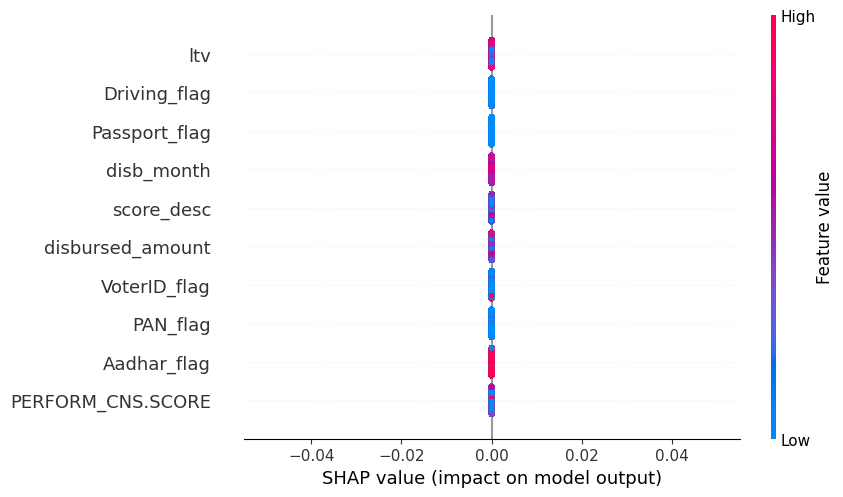

In [46]:
shap.plots.beeswarm(shap_values, max_display=len(selected_features))

In [37]:
n_estimators_list = [5, 10, 15, 25, 50, 100, 120, 300, 500]#, 800, 1200]

max_depth_list = [2, 3, 5, 8, 15, 25, 30, None]

# min_samples_split_list = [2, 5, 10, 15, 100]

# min_samples_leaf_list = [2, 5, 10]

# max_features_list = ['log2', 'sqrt', None]

params_dict={
    'n_estimators': n_estimators_list,
    'max_depth': max_depth_list,
    # 'min_samples_split': min_samples_split_list,
    # 'min_samples_leaf': min_samples_leaf_list,
    # 'max_features': max_features_list
}

results_dict = {}

results_dict['RandomForest'] = {}


for idx in tqdm(range(len(skfold_list))):

    X_train = train_df.iloc[skfold_list[idx][0]].reset_index(drop=True)
    y_train = train_df.iloc[skfold_list[idx][0]]['loan_default'].to_frame().reset_index(drop=True)

    X_valid = train_df.iloc[skfold_list[idx][1]].reset_index(drop=True)
    y_valid = train_df.iloc[skfold_list[idx][1]]['loan_default'].to_frame().reset_index(drop=True)

    for col in created_ratio_list:
        if X_train[col].isnull().sum() != 0:
            X_train[col].fillna(X_train[col].median(), inplace=True)
        if X_valid[col].isnull().sum() != 0:
            X_valid[col].fillna(X_train[col].median(), inplace=True)

    # creating some extra features
    temp_empl_type_map_dict = X_train.groupby('Employment.Type')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_empl_type_map_dict:
        X_train[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_train['Employment.Type'].map(temp_empl_type_map_dict[i_keys])
        X_valid[f"empl_t_{i_keys[0]}_{i_keys[1]}"] = X_valid['Employment.Type'].map(temp_empl_type_map_dict[i_keys])

    temp_disb_month_map_dict = X_train.groupby('disb_month')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_disb_month_map_dict:
        X_train[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_train['disb_month'].map(temp_disb_month_map_dict[i_keys])
        X_valid[f"dm_{i_keys[0]}_{i_keys[1]}"] = X_valid['disb_month'].map(temp_disb_month_map_dict[i_keys])

    temp_score_desc_map_dict = X_train.groupby('score_desc')[
        [
            'ltv', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 
            'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
            'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
            'age', 'hist_length', 'avg_loan_tenure'
        ]
    ].agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_score_desc_map_dict:
        X_train[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_train['score_desc'].map(temp_score_desc_map_dict[i_keys])
        X_valid[f"sd_{i_keys[0]}_{i_keys[1]}"] = X_valid['score_desc'].map(temp_score_desc_map_dict[i_keys])

    temp_aadhar_flag_map_dict = X_train.groupby('Aadhar_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_aadhar_flag_map_dict:
        X_train[f"af_{i_keys[0]}_{i_keys[1]}"] = X_train['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])
        X_valid[f"af_{i_keys[0]}_{i_keys[1]}"] = X_valid['Aadhar_flag'].map(temp_aadhar_flag_map_dict[i_keys])

    temp_pan_flag_map_dict = X_train.groupby('PAN_flag')[['ltv', 'PERFORM_CNS.SCORE']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_pan_flag_map_dict:
        X_train[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_train['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])
        X_valid[f"pf_{i_keys[0]}_{i_keys[1]}"] = X_valid['PAN_flag'].map(temp_pan_flag_map_dict[i_keys])

    temp_voterid_flag_map_dict = X_train.groupby('VoterID_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_voterid_flag_map_dict:
        X_train[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_train['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])
        X_valid[f"vf_{i_keys[0]}_{i_keys[1]}"] = X_valid['VoterID_flag'].map(temp_voterid_flag_map_dict[i_keys])

    temp_driving_flag_map_dict = X_train.groupby('Driving_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_driving_flag_map_dict:
        X_train[f"df_{i_keys[0]}_{i_keys[1]}"] = X_train['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])
        X_valid[f"df_{i_keys[0]}_{i_keys[1]}"] = X_valid['Driving_flag'].map(temp_driving_flag_map_dict[i_keys])

    temp_passport_flag_map_dict = X_train.groupby('Passport_flag')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_passport_flag_map_dict:
        X_train[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_train['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])
        X_valid[f"passf_{i_keys[0]}_{i_keys[1]}"] = X_valid['Passport_flag'].map(temp_passport_flag_map_dict[i_keys])

    temp_state_id_map_dict = X_train.groupby('State_ID')[['ltv', 'PERFORM_CNS.SCORE', 'age', 'hist_length', 'avg_loan_tenure']].\
        agg([np.median, np.mean, get_q25, get_q75, get_iqr]).to_dict()

    for i_keys in temp_state_id_map_dict:
        X_train[f"si_{i_keys[0]}_{i_keys[1]}"] = X_train['State_ID'].map(temp_state_id_map_dict[i_keys])
        X_valid[f"si_{i_keys[0]}_{i_keys[1]}"] = X_valid['State_ID'].map(temp_state_id_map_dict[i_keys])

    # getting categorical features
    flag_columns = [col for col in X_train.columns if col.endswith('_flag') or col.endswith('_Flag')]

    id_columns = [
        'branch_id', 'supplier_id', 'manufacturer_id', 
        'Current_pincode_ID', 'State_ID', 'Employee_code_ID'
    ]

    categorical_features = list(X_train.select_dtypes(include=['object']).columns)
    categorical_features.append('disb_month')
    categorical_features.append('score_desc')
    categorical_features.extend(flag_columns)
    categorical_features.extend(id_columns)

    # getting numerical features
    numerical_features = list(X_train.select_dtypes(exclude=['object']).columns)
    numerical_features.remove('loan_default')
    numerical_features.remove('disb_month')
    numerical_features.remove('score_desc')
    numerical_features.remove('UniqueID')
    for col in flag_columns:
        numerical_features.remove(col)
    for col in id_columns:
        numerical_features.remove(col)

    #getting all features
    all_features = []
    all_features.extend(categorical_features)
    all_features.extend(numerical_features)

    X_train = X_train[all_features]
    X_valid = X_valid[all_features]

    # feature selection

    # feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1, max_iter=30)
    # feat_selector.fit(np.array(X_train), np.array(y_train))
    # selected_features = list(X_train.iloc[:, feat_selector.support_].columns)

    selected_features = selected_features_dict['RandomForestClassifier'][1]['selected_feats']
    remove_id_features = [col for col in selected_features if col.endswith('_ID') or col.endswith('_id')]
    selected_features = [col for col in selected_features if col not in remove_id_features]

    if len(selected_features) == 0:
        continue

    print('Starting grid search!!!')

    model = RandomForestClassifier()

    model_gscv = GridSearchCV(
        model,
        param_grid=params_dict,
        scoring='roc_auc',
        cv=[skfold_list[idx]],
        n_jobs=-1,
        verbose=4
    )

    model_gscv.fit(X_train[selected_features], y_train)

    # model training
    model_gscv.fit(X_train[selected_features], y_train)

    # getting shap values
    explainer = shap.Explainer(model_gscv.predict, X_valid)
    shap_values = explainer(X_valid)

    # metric calculation
    y_train_pred = model_gscv.predict(X_train[selected_features])
    y_train_pred_prob = model_gscv.predict_proba(X_train[selected_features])[:, 1]

    y_valid_pred = model_gscv.predict(X_valid[selected_features])
    y_valid_pred_prob = model_gscv.predict_proba(X_valid[selected_features])[:, 1]

    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)

    valid_acc = accuracy_score(y_valid, y_valid_pred)
    valid_f1 = f1_score(y_valid, y_valid_pred)
    valid_roc_auc = roc_auc_score(y_valid, y_valid_pred_prob)

    results_dict['RandomForest'][idx+1] = {}
    results_dict['RandomForest'][idx+1]['selected_feats'] = selected_features
    results_dict['RandomForest'][idx+1]['train_acc'] = train_acc
    results_dict['RandomForest'][idx+1]['train_f1'] = train_f1
    results_dict['RandomForest'][idx+1]['train_roc_auc'] = train_roc_auc
    results_dict['RandomForest'][idx+1]['valid_acc'] = valid_acc
    results_dict['RandomForest'][idx+1]['valid_f1'] = valid_f1
    results_dict['RandomForest'][idx+1]['valid_roc_auc'] = valid_roc_auc
    results_dict['RandomForest'][idx+1]['model'] = model
    results_dict['RandomForest'][idx+1]['shap_values'] = shap_values
    results_dict['RandomForest'][idx+1]['best_params'] = model_gscv.best_params_

    print(f"##### Fold{idx+1} #####")
    print(f"Selected features: {selected_features}")
    print("Train:")
    print(f"Accuracy: {train_acc:.5f}, F1: {train_f1:.5f}, ROC-AUC: {train_roc_auc:.5f}")
    print("Validation:")
    print(f"Accuracy: {valid_acc:.5f}, F1: {valid_f1:.5f}, ROC-AUC: {valid_roc_auc:.5f}")

    del X_train, y_train, X_valid, y_valid
    del temp_empl_type_map_dict, temp_disb_month_map_dict, temp_score_desc_map_dict
    del temp_aadhar_flag_map_dict, temp_pan_flag_map_dict, temp_voterid_flag_map_dict
    del temp_driving_flag_map_dict, temp_passport_flag_map_dict, temp_state_id_map_dict
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

Starting grid search!!!
Fitting 1 folds for each of 72 candidates, totalling 72 fits


  0%|          | 0/10 [00:06<?, ?it/s]


IndexError: indices are out-of-bounds

In [32]:
[col for col in selected_features if col.endswith('_ID') or col.endswith('_id')]

['State_ID',
 'branch_id',
 'manufacturer_id',
 'Current_pincode_ID',
 'Employee_code_ID',
 'supplier_id']

In [28]:
selected_features

['PERFORM_CNS.SCORE',
 'Aadhar_flag',
 'PAN_flag',
 'State_ID',
 'VoterID_flag',
 'branch_id',
 'disbursed_amount',
 'score_desc',
 'disb_month',
 'manufacturer_id',
 'Passport_flag',
 'Current_pincode_ID',
 'Driving_flag',
 'Employee_code_ID',
 'supplier_id',
 'ltv']

In [ ]:
for idx in results_dict['RandomForest']:
    print(f"##### Fold{idx} #####")
    print(f"Selected features: {results_dict['RandomForest'][idx]['selected_features']}")
    print("Train:")
    print(f"Accuracy: {results_dict['RandomForest'][idx]['train_acc']}")
    print(f"F1: {results_dict['RandomForest'][idx]['train_f1']}")
    print(f"ROC-AUC: {results_dict['RandomForest'][idx]['train_roc_auc']}")
    print("Validation:")
    print(f"Accuracy: {results_dict['RandomForest'][idx]['valid_acc']}")
    print(f"F1: {results_dict['RandomForest'][idx]['valid_f1']}")
    print(f"ROC-AUC: {results_dict['RandomForest'][idx]['valid_roc_auc']}")

Index(['Current_pincode_ID', 'ltv'], dtype='object')

In [ ]:
train_acc_list = [results_dict['RandomForest'][i]['train_acc'] for i in results_dict['RandomForest']]
train_f1_list = [results_dict['RandomForest'][i]['train_f1'] for i in results_dict['RandomForest']]
train_roc_auc_list = [results_dict['RandomForest'][i]['train_roc_auc'] for i in results_dict['RandomForest']]

valid_acc_list = [results_dict['RandomForest'][i]['valid_acc'] for i in results_dict['RandomForest']]
valid_f1_list = [results_dict['RandomForest'][i]['valid_f1'] for i in results_dict['RandomForest']]
valid_roc_auc_list = [results_dict['RandomForest'][i]['valid_roc_auc'] for i in results_dict['RandomForest']]

results_df = pd.DataFrame()
results_df['fold'] = [i for i in results_dict['RandomForest']]
results_df['train_acc'] = train_acc_list
results_df['train_f1'] = train_f1_list
results_df['train_roc_auc'] = train_roc_auc_list
results_df['valid_acc'] = valid_acc_list
results_df['valid_f1'] = valid_f1_list
results_df['valid_roc_auc'] = valid_roc_auc_list

results_df

In [21]:
train_df.isnull().sum().sum()

296

In [22]:
train_df['Aadhar_flag'].isnull().sum()

0

In [54]:
X_train = train_df.iloc[skfold_list[0][0]].reset_index(drop=True)

for col in created_ratio_list:
    if X_train[col].median() != 0:
        print(f"{col}: {X_train[col].median()}")

In [55]:
for col in created_ratio_list:
    if X_train[col].isnull().sum() != 0:
        X_train[col].fillna(X_train[col].median(), inplace=True)
        print(f"{col}: {X_train[col].max()}")